In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import jetsimpy as grb
from astropy.cosmology import Planck15 as cosmo

def lc_plot(
        jetType, loge0, logepsb, logepse, logn0, thc, thv, p, z,
        observed_data, observed_data_fit):
    fig, ax = plt.subplots(2, 2, figsize=(10, 6),sharex=True, sharey=True)
    _lc_plot(
        ax[0,0], jetType, loge0*0.99, logepsb, logepse, logn0, thc, thv*0.99, p, z,
        observed_data, observed_data_fit)
    _lc_plot(
        ax[0,1], jetType, loge0*0.99, logepsb, logepse, logn0, thc, thv*1.01, p, z,
        observed_data, observed_data_fit)
    _lc_plot(
        ax[1,0], jetType, loge0*1.01, logepsb, logepse, logn0, thc, thv*0.99, p, z,
        observed_data, observed_data_fit)
    _lc_plot(
        ax[1,1], jetType, loge0*1.01, logepsb, logepse, logn0, thc, thv*1.01, p, z,
        observed_data, observed_data_fit)
    
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel(r'$t$ (s)')
    fig.tight_layout()

    #print("Saving plots/lc_afterflow_obs_matching.pdf")
    #fig.savefig("plots/lc_afterflow_obs_matching.pdf", format='pdf', bbox_inches='tight')
    plt.show()
    plt.close(fig)

def _lc_plot(
        ax, jetType, loge0, logepsb, logepse, logn0, thc, thv, p, z,
        observed_data, observed_data_fit):
    # Jet Parameters
    dl = cosmo.luminosity_distance(z).to("Mpc").value  # Luminosity distance in Mpc
    #print(f"Luminosity distance: {dl} Mpc")
    Z = {'theta_v':    thv,   # Viewing angle in radians
        'Eiso':        10**loge0, # Isotropic-equivalent energy in erg
        'theta_c':     thc,    # Half-opening angle in radians
        'n0':          10**logn0,    # circumburst density in cm^{-3}
        'p':           p,    # electron energy distribution index
        'eps_e':       10**logepse,    # epsilon_e
        'eps_b':       10**logepsb,   # epsilon_B
        'd':           dl, # Luminosity distance in cm
        'z':           z,   # redshift
        'A':           0,
        'lf':          300,
        's':           6,
    }

    # Time and Frequencies
    ta = 1.0e-2 * 86400
    tb = 1.0e2 * 86400
    t = np.geomspace(ta, tb, num=100)

    df_allobs = pd.read_csv(observed_data)
    df_fit = pd.read_csv(observed_data_fit)

    frequencies = df_allobs[['Filt','Freqs']].drop_duplicates().sort_values(by='Freqs').to_numpy()

    cmap = get_cmap('rainbow')  # or 'plasma', 'cividis', 'magma'
    colors = cmap(np.linspace(0, 1, len(frequencies)))

    for i, (band,nu) in enumerate(frequencies):
        #print(f"Calculating for frequency: {nu}")
        Fnu_model = []

        if jetType == 'powerlaw':
            Fnu_model = grb.FluxDensity_powerlaw(t, nu, Z)
        elif jetType == 'gaussian':
            Fnu_model = grb.FluxDensity_gaussian(t, nu, Z)
        elif jetType == 'tophat':
            Fnu_model = grb.FluxDensity_tophat(t, nu, Z)
        else:
            raise ValueError(f"Invalid jet type: {jetType}")

        Fnu_model = np.array(Fnu_model)

        Fnu_allobs = df_allobs[df_allobs['Filt']==band][['Times','Fluxes', 'FluxErrs']].sort_values(by='Times').to_numpy()
        Fnu_fit = df_fit[df_fit['Filt']==band][['Times','Fluxes', 'FluxErrs']].sort_values(by='Times').to_numpy()


        ax.plot(t, Fnu_model,  linestyle='dashed', linewidth=1.0, label=f'{band}', color=colors[i])

        ax.errorbar(
            Fnu_allobs[:,0], Fnu_allobs[:,1],
            yerr=Fnu_allobs[:,2],
            fmt='x', linestyle='solid',
            markersize=4, alpha=0.3,
            color=colors[i], ecolor=colors[i],
            elinewidth=0.5, capsize=2
        )    
        ax.scatter(Fnu_fit[:,0], Fnu_fit[:,1], marker='*', s=100, color=colors[i])


    # Create text content with all Z dictionary values
    z_text = f"Parameters:\njetType: {jetType}"
    for key, value in Z.items():
        if key in ['specType', 'z', 'E0']:
            continue
            # Skip function objects, just show the key
            #z_text += f"{key}: {type(value).__name__}\n"
        else:
            z_text += '\n'
            # Format numerical values
            if isinstance(value, (int, float)):
                if abs(value) >= 1e6 or (abs(value) < 1e-3 and value != 0):
                    z_text += f"{key}: {value:.2e}"
                else:
                    z_text += f"{key}: {value:.4f}"
            else:
                z_text += f"{key}: {value}"
    
    # Add textbox with all Z dictionary values
    ax.text(0.98, 0.02, z_text, transform=ax.transAxes,
            bbox=dict(boxstyle="round,pad=0.5", facecolor="white", alpha=0.5, edgecolor='none'),
            verticalalignment='bottom', horizontalalignment='right', fontsize=10, fontfamily='monospace')
    
    #marker_text = "*  Observations used for fitting\nx  All observations\nDashed lines show the best fit"
    #ax.text(0.2, 0.02, marker_text, transform=ax.transAxes, 
    #        bbox=dict(boxstyle="round,pad=0.5", facecolor="white", alpha=0.9, edgecolor="black"),
    #        verticalalignment='bottom', fontsize=10, fontfamily='monospace')
    
    ax.legend(edgecolor='none', loc="lower left", ncol=2)


# Tophat jet

/var/folders/wz/tf9bd1d17kxcg2r9f2875tv00000gn/T/ipykernel_64388/4207391626.py:65: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap('rainbow')  # or 'plasma', 'cividis', 'magma'
/var/folders/wz/tf9bd1d17kxcg2r9f2875tv00000gn/T/ipykernel_64388/4207391626.py:65: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap('rainbow')  # or 'plasma', 'cividis', 'magma'
/var/folders/wz/tf9bd1d17kxcg2r9f2875tv00000gn/T/ipykernel_64388/4207391626.py:65: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_

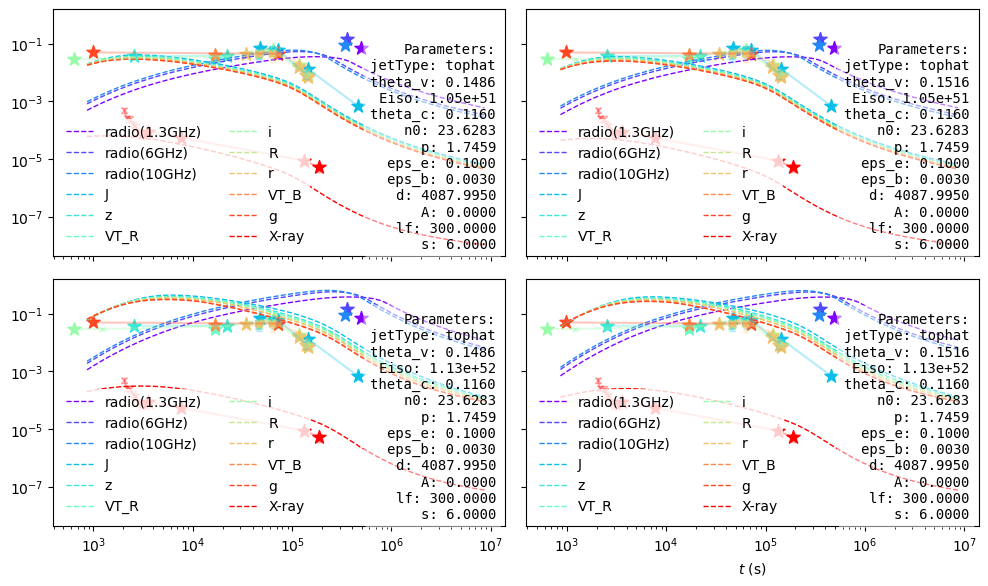

In [18]:
lc_plot(jetType='tophat',
    loge0=51.53774335, logepsb=-2.52729443, logepse=-1, logn0=1.37343178, thc=0.11597174, thv=0.15006594, p=1.74590904,
    z=0.661,
    observed_data='data/mcmc_df.csv',
    observed_data_fit='data/mcmc_df_trunc.csv',) 
